# How do truth representations of sloppy addition models generalize?


## 1. Generalization across contexts

**BEFORE RUNNING** make sure you have trained probes and gathered transfer predictions using `python run_elk.py --experiment context_generalization --model <model> --p-err <p-err>`

`model` is a path or huggingface name to a finetuned model to evaluate, and `p-err` is the probability of arithmetic errors to use for the evaluation dataset (should usually be the `p-err` used to train the model, which is often 1.0).

Then modify `dir_template` below to point to the output results, along with other parameters of the experiment.

In [1]:
import os
del os.environ["HF_DATASETS_CACHE"]

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

from results_utils import measure_auroc_across_layers, get_raw_logprobs


### PICK THESE PARAMETERS ###
fr = "alice"  # probe was trained on this context and against this label set
to = "alice"  # probe is evaluated on this context
filter_by_disagree = True  # whether to keep only examples where Alice and Bob disagree
versions = [1697125056] # 1692471371 or 1692472192, which finetuned model to use
inlp_iter = 0  # which classifier from iterative nullspace projection to use, 0 corresponds to standard logistic regression
dir_template = "/mnt/ssd-1/alexm/elk/elk-reporters/pythia-410m-v{version}" \
    "/atmallen/sloppy_addition_{fr}_{p_err}/transfer/atmallen/sloppy_addition_{to}_{p_err}/logprobs.pt"

raw_logprobs = {v: get_raw_logprobs(fr, to, p_err=1.0, version=v, dir_template=dir_template) for v in versions}
# raw_logprobs = old_logprobs
results_dfs = {v: measure_auroc_across_layers(raw_logprobs, "alice", filter_by_disagree, "none", inlp_iter) for v, raw_logprobs in raw_logprobs.items()}
for v in versions:
    del results_dfs[v]["ens"]
    del results_dfs[v]["inlp_iter"]
    del results_dfs[v]["against"]

results_df = sum((results_dfs[versions[i]] for i in range(1, len(versions))), start=results_dfs[versions[0]]) / len(versions)

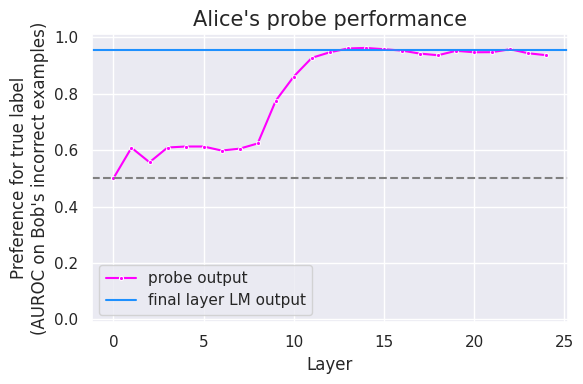

In [7]:
plt.figure(figsize=(6,4))
sns.lineplot(data=results_df, x="layer", y="lr_auroc", label="probe output", marker=".", color="fuchsia")
lm_auroc = results_df["lm_auroc"].iloc[0]
plt.axhline(y=lm_auroc, color="dodgerblue", linestyle="-", label="final layer LM output")
for rdf in results_dfs.values():
    sns.lineplot(data=rdf, x="layer", y="lr_auroc", label=None, color="fuchsia", alpha=0.5, linewidth=0.5)
    plt.axhline(y=rdf["lm_auroc"].iloc[0], color="dodgerblue", linestyle="-", label=None, alpha=0.5, linewidth=0.5)
plt.legend()
plt.axhline(y=0.5, color="grey", linestyle="--")

plt.ylim(-0.01, 1.01)

plt.xlabel("Layer")
if filter_by_disagree:
    plt.ylabel(f"Preference for true label\n(AUROC on Bob's incorrect examples)")
else:
    plt.ylabel(f"AUROC against true labels")
if fr == to:
    title = f"{fr.capitalize()}'s probe performance"
else:
    title = f"Probe transfer performance: {fr.capitalize()} → {to.capitalize()}"
plt.title(title, fontsize=15)
plt.tight_layout()

plt.show()

## 1. Easy to hard generalization

**BEFORE RUNNING** make sure you have trained probes and gathered transfer predictions using `python run_elk.py --experiment easy_vs_hard --model <model> --p-err <p-err>`

Then modify `dir_template` below to point to the output results, along with other parameters of the experiment.

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

from results_utils import measure_auroc_across_layers, get_raw_logprobs

### PICK THESE PARAMETERS ###
fr = "hard_4"  # probe was trained on this context and against this label set
to = "hard_4"  # probe is evaluated on this context
against = "alice"  # probe is evaluated against this label set
version = 1697125056 # 1692471371 or 1692472192, which finetuned model to use
ens = "none"  # "none" or "full", this is only meaningful if multiple variants are used in ELK, otherwise both are equivalent to "none"
inlp_iter = 0  # which classifier from iterative nullspace projection to use, 0 corresponds to standard logistic regression
# dir_template = "/mnt/ssd-1/alexm/elk/elk-reporters/Llama-2-7b-hf-v{version}/atmallen/sloppy_addition_alice_{p_err}_{fr}/transfer/atmallen/sloppy_addition_alice_{p_err}_{to}/logprobs.pt"
dir_template = "/mnt/ssd-1/alexm/elk/elk-reporters/pythia-410m-v{version}" \
    "/atmallen/sloppy_addition_alice_{p_err}_{fr}/transfer/atmallen/sloppy_addition_alice_{p_err}_{to}/logprobs.pt"

raw_logprobs = get_raw_logprobs(fr, to, p_err=1.0, version=version, dir_template=dir_template)
results_df = measure_auroc_across_layers(raw_logprobs, against, ens, inlp_iter)

# results_df = measure_auroc_across_layers(raw_logprobs, "alice", "none", 0)
sns.lineplot(data=results_df, x="layer", y="lr_auroc", label="LR", marker=".")
sns.lineplot(data=results_df, x="layer", y="lm_auroc", label="LM")
plt.axhline(y=0.5, color="grey", linestyle="--")

plt.ylim(0, 1.0)

plt.xlabel("Layer")
plt.ylabel(f"AUROC against {against.capitalize()}'s labels")
plt.title(f"Probe trained on {fr.capitalize()} context and labels,\nevaluated on {to.capitalize()} context, using {against.capitalize()}'s labels\nVersion: {version} | Ensembling: {ens} | INLP iteration: {inlp_iter}")
plt.suptitle(f"{fr.capitalize()} → {to.capitalize()} | {against.capitalize()}'s labels")
plt.tight_layout()

plt.show()

KeyError: 0